In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
import os
import pickle
import librosa
import librosa.display
import tensorflow as tf
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
import IPython
import librosa.display as lplt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
import math
import json
from sklearn.model_selection import train_test_split 


In [4]:
ornek_parca="/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/louis-armstrong-what-a-wonderful-world-lyrics.mp3"

In [5]:
#librosa ile ses dosyasini yukluyoruz
signal,sample_rate=librosa.load(ornek_parca)

In [6]:
print(signal)

[ 0.          0.          0.         ... -0.01115751 -0.01232407
  0.        ]


In [7]:
print(sample_rate)

22050


In [8]:
sekil_boyutu=(16,8)

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\3872071639.py:3: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(signal,sample_rate,alpha=0.5)


Text(0.5, 1.0, 'Waveform')

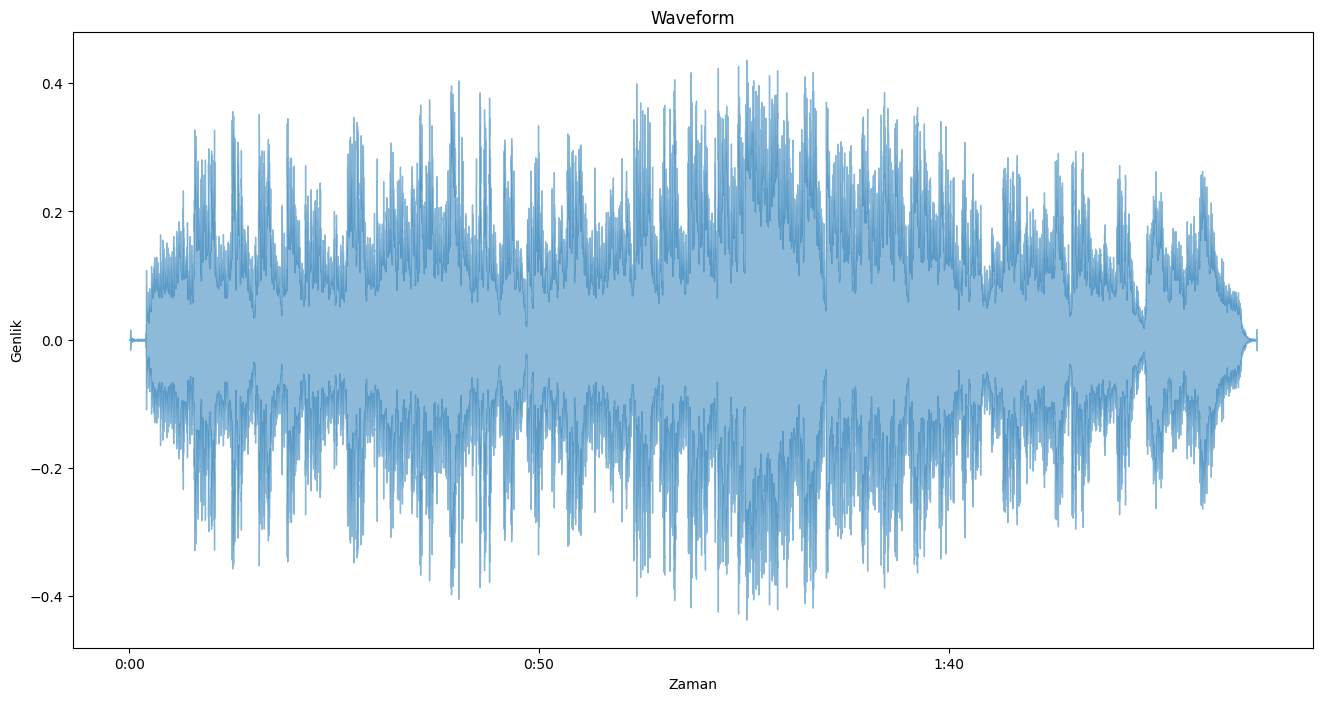

In [9]:
#Waveform(dalga)
plt.figure(figsize=sekil_boyutu)
librosa.display.waveshow(signal,sample_rate,alpha=0.5)
plt.xlabel("Zaman")
plt.ylabel("Genlik")
plt.title("Waveform")

In [10]:
#Fouriier Transform
fft=np.fft.fft(signal)

In [11]:
#buyukluk hesaplama(abs degerleri )
spectrum=np.abs(fft)

In [12]:
#Doğrulanabilir frekansları olusturuyoruz
f=np.linspace(0,sample_rate,len(spectrum))

Text(0.5, 1.0, 'Power Spectrum')

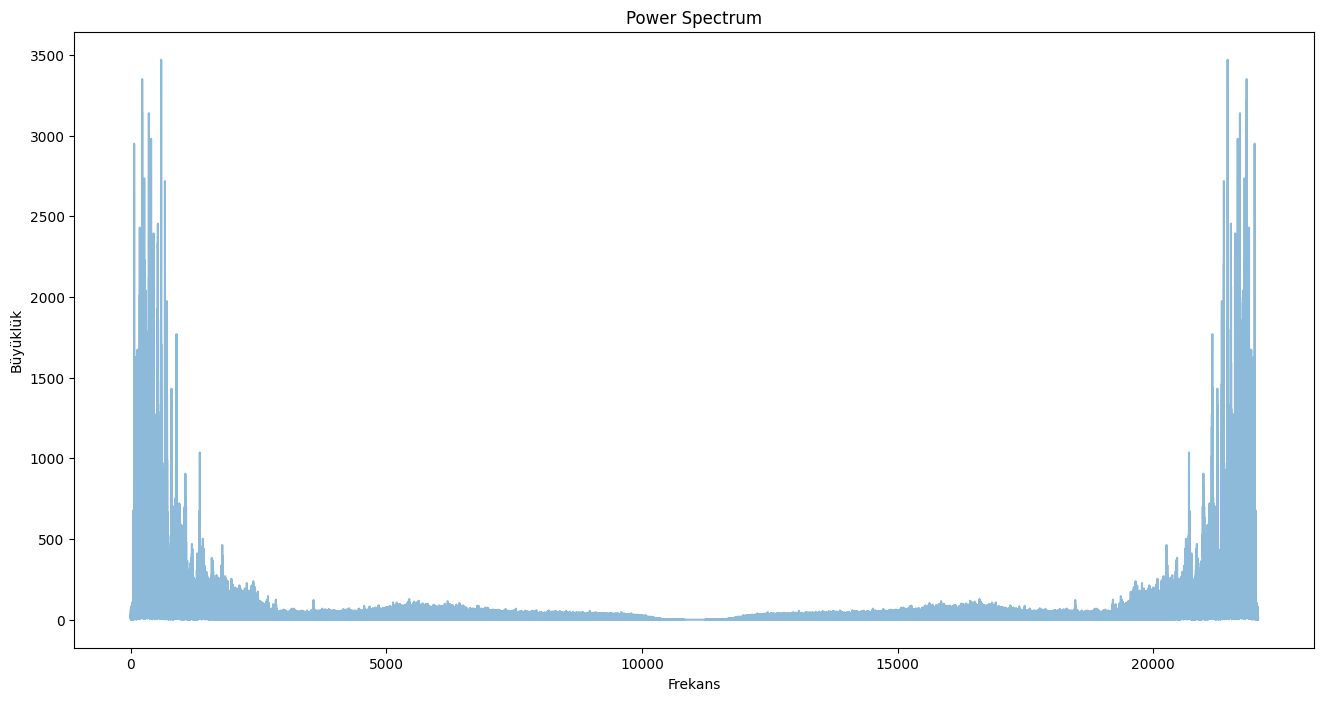

In [13]:
plt.figure(figsize=sekil_boyutu)
plt.plot(f,spectrum,alpha=0.5)
plt.xlabel("Frekans")
plt.ylabel("Büyüklük")
plt.title("Power Spectrum")

In [14]:
#spektrumun ve frekansın yarısını alıyoruz
left_spectrum=spectrum[:int(len(spectrum)/2)]
left_f=f[:int(len(spectrum)/2)]

Text(0.5, 1.0, 'Power Spectrum')

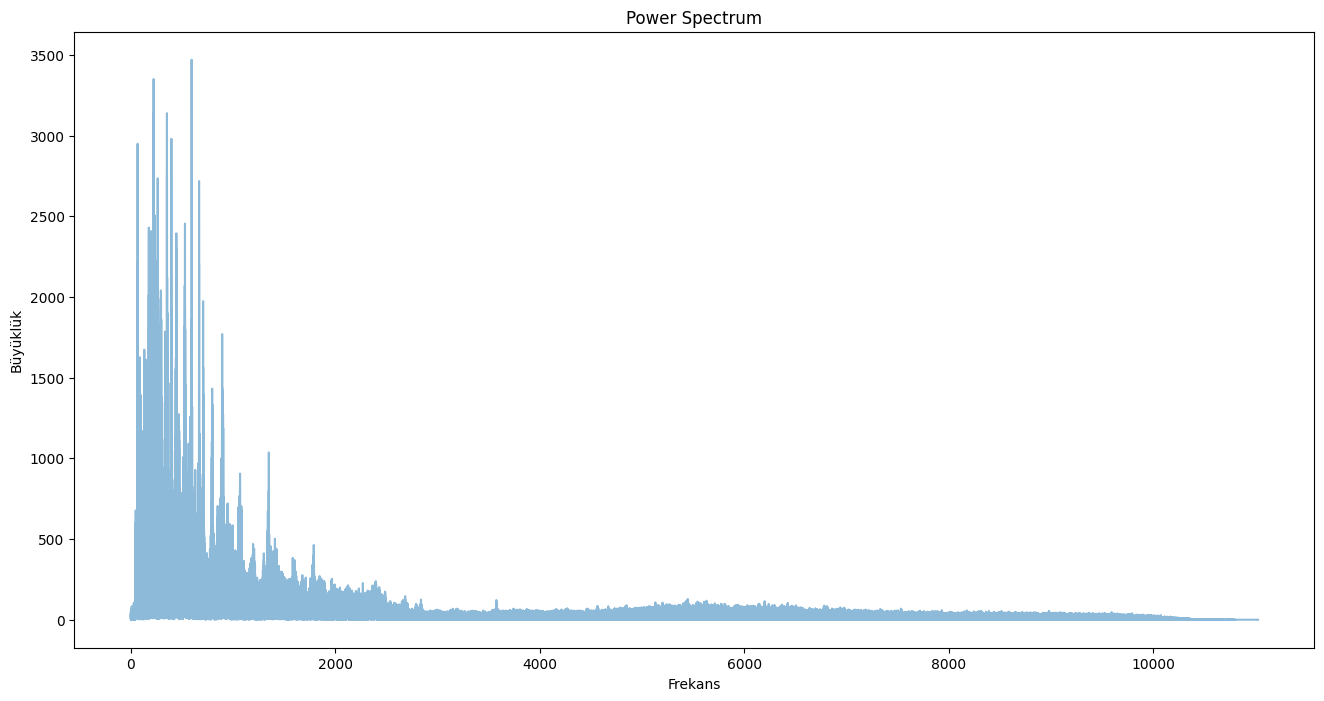

In [15]:
#spectrum cizimi
plt.figure(figsize=sekil_boyutu)
plt.plot(left_f,left_spectrum,alpha=0.5)
plt.xlabel("Frekans")
plt.ylabel("Büyüklük")
plt.title("Power Spectrum")

In [16]:
#SPEKTROGRAM(STFT)
hop_length=512 # ornek sayısı
n_fft=2048 #pencere icin ornek sayısı


In [17]:
#stft performans
stft=librosa.stft(signal,n_fft=n_fft,hop_length=hop_length)

In [18]:
spectrogram=np.abs(stft)

Text(0.5, 1.0, 'Spectrogram')

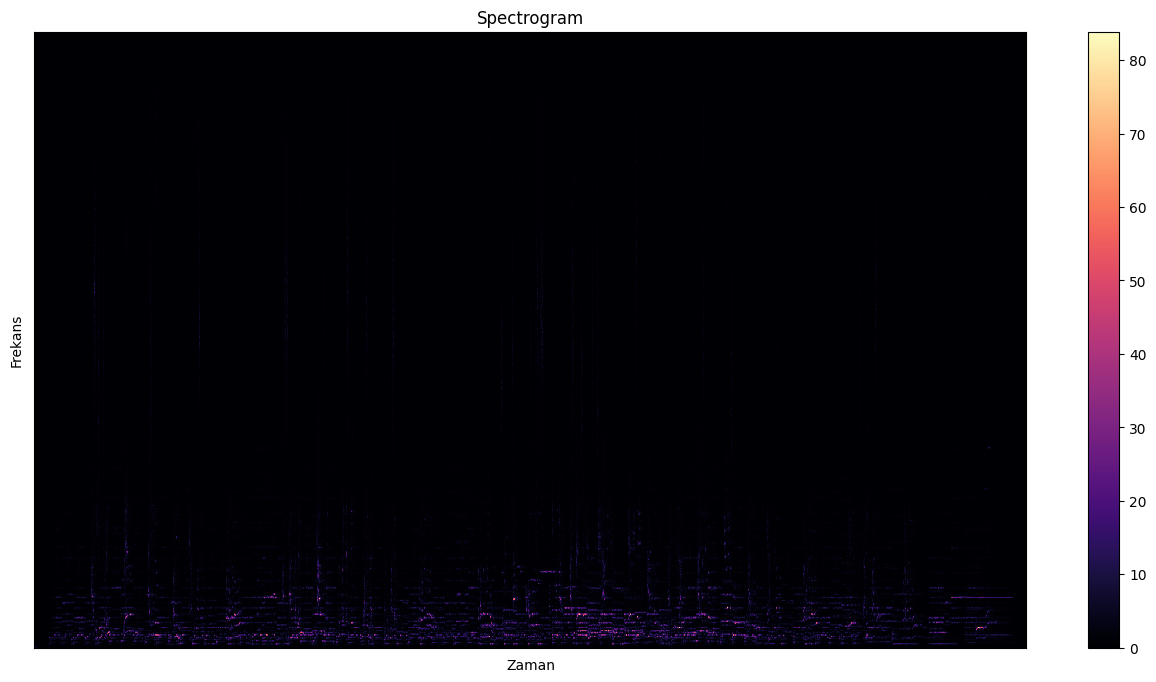

In [19]:
#spectrogram çizimi
plt.figure(figsize=sekil_boyutu)
librosa.display.specshow(spectrogram,sr=sample_rate,hop_length=hop_length)
plt.xlabel("Zaman")
plt.ylabel("Frekans")
plt.colorbar()
plt.title("Spectrogram")

In [20]:
#desibel cinsinden değerler elde etmek için logaritma uyguluyoruz
log_spectrogram=librosa.amplitude_to_db(spectrogram)

Text(0.5, 1.0, 'Spectrogram(Decibel)')

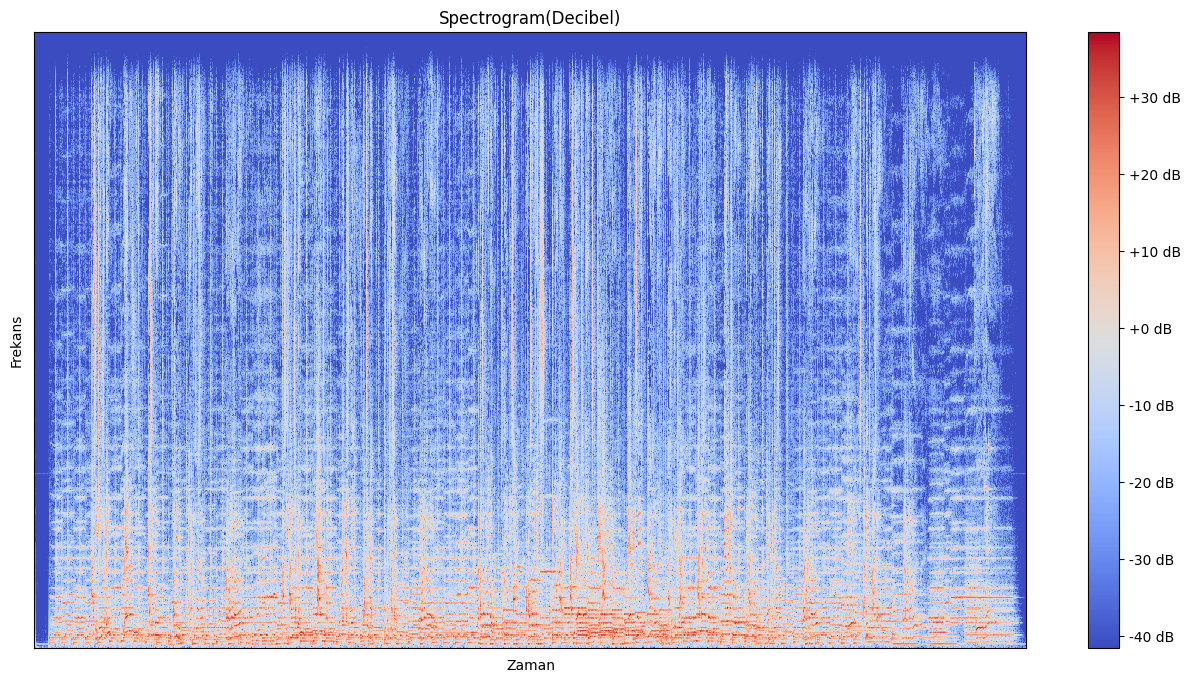

In [21]:
#decibel cinisnden spectrogram cizimi
plt.figure(figsize=sekil_boyutu)
librosa.display.specshow(log_spectrogram,sr=sample_rate,hop_length=hop_length)
plt.xlabel("Zaman")
plt.ylabel("Frekans")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram(Decibel)")

In [22]:
#MFCC sinyali
mfccs=librosa.feature.mfcc(signal,sample_rate,n_fft=n_fft,hop_length=hop_length,n_mfcc=13)

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\3885300114.py:2: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01115751 -0.01232407
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs=librosa.feature.mfcc(signal,sample_rate,n_fft=n_fft,hop_length=hop_length,n_mfcc=13)


Text(0.5, 1.0, 'MFCCs')

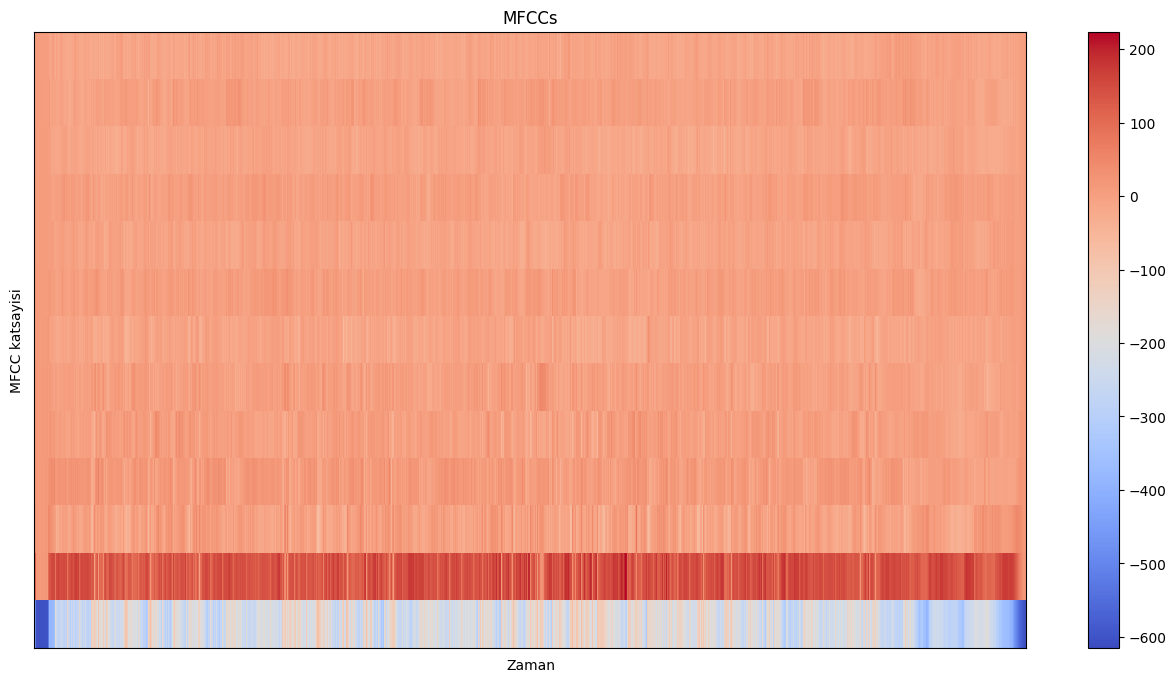

In [23]:
#MFCC sinyali cizimi
plt.figure(figsize=sekil_boyutu)
librosa.display.specshow(mfccs,sr=sample_rate,hop_length=hop_length)
plt.xlabel("Zaman")
plt.ylabel("MFCC katsayisi")
plt.colorbar()
plt.title("MFCCs")

In [24]:

DATASET_PATH="/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/"
JSON_PATH="data_10.json"
SAMPLE_RATE=22050 #ornek oranı
TRACK_DURATION=30 #parca uzunluk suresi
SAMPLE_PER_TRACK=SAMPLE_RATE*TRACK_DURATION

In [25]:
def save_mfcc(dataset_path,json_path,n_mfcc=13,n_fft=2048,hop_length=512,num_segment=5):
    """müzik veri kümesinden mfcc'leri çikarip  bunlari tür etiketleriyle birlikte bir json dosyasina kaydediyoruz"""
    
    #Mapping,Labels ve mfcc'leri saklamak için sözlük oolusturduk
    data={
        "mapping":[],
        "labels":[],
        "mfcc":[]
    }
    samples_per_segments=int(SAMPLE_PER_TRACK/num_segment)
    num_mfcc_vectors_per_segment=math.ceil(samples_per_segments / hop_length)

     # tüm tür alt kategorilerinde döngü ile erisiyoruz
    for i ,(dirpath,dirnames,filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            # labeli mappinge kaydediyoruz
            semantic_label=dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\n Proccesing: {}".format(semantic_label))

            #tüm ses dosyalarını alt dizine işliyoruz
            for f in filenames:
                #ses dosyasını yukluyoruz
                file_path=os.path.join(dirpath,f)
                signal,sr=librosa.load(file_path,sr=SAMPLE_RATE)
                #ses dosyasinin tum bolumlerini isliyoruz
                for d in range(num_segment):
                    #geçerli segment için başlangıç ve bitiş örneğini hesapliyoruz
                    start=samples_per_segments*d
                    finish=start+samples_per_segments

                    mfcc=librosa.feature.mfcc(signal[start:finish],
                    sr=sr,
                    n_fft=n_fft,
                    n_mfcc=n_mfcc,
                    hop_length=hop_length)
                    mfcc=mfcc.T

                    if len(mfcc)==num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path,d+1))
    #MFCCs'yi json dosyasına kaydediyoruz                    
    with open(json_path,"w") as fp:
        json.dump(data,fp,indent=4)
save_mfcc(DATASET_PATH,JSON_PATH,num_segment=10)        










        






 Proccesing: blues
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00000.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00000.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00000.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00000.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00000.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00000.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00000.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00000.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00000.wav, segment:9
/Users/evsin/OneDrive/Masa

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00732422  0.01660156  0.00762939 ... -0.04373169 -0.05706787
 -0.04086304] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.02481079 -0.02005005 -0.0357666  ...  0.00918579  0.03964233
  0.09030151] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.06256104  0.02435303 -0.00405884 ...  0.2854004   0.29364014
  0.25228882] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00001.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00001.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00001.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00001.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00001.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00002.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00002.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00002.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00002.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00271606 -0.0038147  -0.00408936 ... -0.15942383 -0.14642334
 -0.13192749] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.13513184 -0.11825562 -0.10083008 ...  0.23010254  0.19979858
  0.24316406] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.22213745  0.21331787  0.24920654 ... -0.07080078 -0.06463623
 -0.06201172] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00003.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00003.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00003.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00003.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00004.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00004.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00004.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00004.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00004.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.1564331  -0.13809204 -0.12841797 ...  0.05422974  0.05551147
  0.05358887] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.04498291  0.04144287  0.0401001  ... -0.24215698 -0.23568726
 -0.2268982 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.2144165  -0.19995117 -0.18859863 ... -0.00515747 -0.00244141
  0.00283813] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00006.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00006.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00006.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00006.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00006.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00006.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00006.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00006.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00006.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_sini

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.1602478  -0.1315918  -0.13806152 ...  0.01309204 -0.00289917
  0.00927734] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.03234863  0.04876709  0.04525757 ... -0.18478394 -0.16964722
 -0.18118286] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.1786499  -0.17822266 -0.27142334 ... -0.11068726 -0.12548828
 -0.11709595] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00010.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00010.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00010.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00010.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00011.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00011.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00011.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00011.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00011.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.23721313  0.23873901  0.21276855 ... -0.01016235  0.01092529
  0.02752686] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.01843262  0.00799561 -0.00250244 ...  0.09658813  0.09082031
  0.0703125 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.03726196 -0.00561523 -0.05566406 ... -0.06948853 -0.07192993
 -0.07434082] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00012.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00012.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00012.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00013.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00013.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00013.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00013.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00013.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00013.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.2626648  -0.3711548  -0.42617798 ...  0.02038574  0.01742554
  0.01348877] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.01422119 0.01419067 0.01141357 ... 0.00927734 0.02270508 0.04385376] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.13864136 -0.20974731 -0.1781311  ... -0.02038574 -0.05319214
  0.01602173] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175865324

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00014.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00014.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00014.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00014.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00014.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00015.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00015.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00015.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00015.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.03167725 -0.01641846 -0.01074219 ... -0.06561279 -0.08004761
 -0.04623413] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.00778198 0.03582764 0.01824951 ... 0.20837402 0.29507446 0.26257324] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.13458252 -0.02017212 -0.14025879 ... -0.15866089 -0.16131592
 -0.15661621] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175865324

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00016.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00016.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00016.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00016.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00016.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00016.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00016.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00017.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00017.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.02355957 -0.02905273 -0.03234863 ...  0.05758667  0.06027222
  0.06469727] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.05981445  0.04962158  0.03817749 ... -0.006073    0.0022583
  0.00579834] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00442505  0.00137329  0.00210571 ... -0.04815674 -0.0536499
 -0.05999756] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00018.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00018.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00018.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00018.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00018.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00018.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00018.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00018.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00019.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01565552 -0.01956177 -0.02178955 ... -0.01187134 -0.01525879
 -0.01922607] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.02206421 -0.02072144 -0.02157593 ... -0.06100464 -0.05944824
 -0.05975342] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.05862427 -0.05255127 -0.04321289 ...  0.05664062  0.05273438
  0.04840088] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00020.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00020.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00020.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00020.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00020.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00020.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00020.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00021.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00021.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.02624512 -0.02209473 -0.01513672 ... -0.06619263 -0.07910156
 -0.08291626] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.08105469 -0.08041382 -0.07846069 ...  0.00149536 -0.00393677
 -0.00344849] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00604248 -0.01098633 -0.01846313 ... -0.00775146 -0.01626587
 -0.02200317] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00022.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00022.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00022.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00022.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00022.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00022.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00022.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00022.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00022.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_sini

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.07141113 -0.07553101 -0.08236694 ... -0.00738525 -0.00476074
 -0.00341797] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00076294  0.00387573  0.00714111 ...  0.05697632  0.05285645
  0.0480957 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.04229736  0.04202271  0.04974365 ... -0.06280518 -0.05908203
 -0.05596924] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00024.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00024.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00024.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00024.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00024.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00024.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00024.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00024.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00024.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_sini

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.01922607  0.02081299  0.01873779 ... -0.00015259  0.08505249
  0.11785889] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.08392334  0.01055908 -0.05911255 ...  0.11273193  0.11004639
  0.10852051] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.10601807  0.10076904  0.09567261 ... -0.15338135 -0.19613647
 -0.20742798] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00026.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00026.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00026.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00026.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00027.wav, segment:1


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.10919189  0.0534668  -0.00604248 ...  0.02105713  0.01971436
  0.0201416 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.01931763 0.01940918 0.02130127 ... 0.03640747 0.02789307 0.02307129] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.02609253  0.03457642  0.04318237 ... -0.2182312  -0.2472229
 -0.26550293] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00027.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00027.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00027.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00027.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00027.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00027.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00027.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00027.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00027.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.03042603 -0.0305481  -0.0328064  ... -0.02294922 -0.03448486
 -0.01168823] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.02890015 0.05358887 0.04248047 ... 0.09619141 0.11535645 0.12390137] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.11422729  0.08398438  0.0491333  ... -0.02178955 -0.01571655
  0.00387573] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175865324

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00028.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00029.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00029.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00029.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00029.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00029.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00029.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00029.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00029.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01669312 -0.02764893 -0.02191162 ... -0.07833862 -0.10662842
 -0.11581421] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.12060547 -0.1298523  -0.14505005 ... -0.322937   -0.3201294
 -0.32821655] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.32989502 -0.31817627 -0.31674194 ...  0.2723999   0.28546143
  0.29327393] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00030.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00030.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00030.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00030.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00030.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00031.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00031.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00031.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00031.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01205444 -0.02322388 -0.02194214 ...  0.08135986  0.04956055
  0.01828003] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00128174 -0.02716064 -0.02966309 ...  0.04873657  0.04074097
  0.02758789] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.01834106  0.01190186 -0.00024414 ... -0.22518921 -0.21972656
 -0.21270752] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00032.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00032.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00032.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00032.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00032.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00032.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00032.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00032.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00032.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_sini

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00836182 -0.01040649 -0.01641846 ...  0.02008057  0.02416992
  0.02270508] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.02435303 0.02676392 0.0291748  ... 0.18234253 0.14883423 0.184021  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.18869019 0.19281006 0.23617554 ... 0.04275513 0.04284668 0.04006958] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00033.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00033.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00033.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00033.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00033.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00033.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00033.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00033.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00033.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_sini

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.01361084  0.02810669  0.03515625 ...  0.01953125 -0.01785278
 -0.06161499] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.09332275 -0.13497925 -0.16769409 ... -0.08416748 -0.06729126
 -0.04238892] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.0269165  -0.02645874 -0.01486206 ... -0.17825317 -0.18200684
 -0.18432617] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00034.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00034.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00034.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00034.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00034.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00034.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00034.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00034.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00034.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_sini

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.03277588 -0.04876709 -0.04104614 ... -0.2687378  -0.27996826
 -0.28775024] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.26080322 -0.21704102 -0.19403076 ... -0.31582642 -0.37582397
 -0.41809082] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.40792847 -0.40481567 -0.38723755 ...  0.09472656  0.11541748
  0.1036377 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00035.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00035.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00035.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00035.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00035.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00035.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00035.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00035.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00035.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_sini

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.06143188  0.0383606   0.00845337 ... -0.3425293  -0.3126526
 -0.33065796] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.36886597 -0.38967896 -0.3996277  ... -0.13409424 -0.16775513
 -0.2166748 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.25335693 -0.28329468 -0.3143921  ... -0.3293152  -0.27041626
 -0.24902344] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00037.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00037.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00037.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00037.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00037.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00037.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00037.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00037.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00037.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_sini

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01089478 -0.01052856 -0.00549316 ...  0.10092163  0.09179688
  0.06292725] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.0440979   0.00701904 -0.06738281 ... -0.02676392 -0.06311035
 -0.08627319] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.10067749 -0.11077881 -0.10714722 ...  0.05584717  0.04394531
  0.03366089] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00038.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00038.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00038.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00038.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00038.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00038.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00038.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00038.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00038.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_sini

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.03094482 -0.0640564  -0.0640564  ...  0.00588989  0.01312256
 -0.01074219] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.05044556 -0.02935791 -0.01745605 ...  0.17056274  0.19329834
  0.1892395 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.1885376  0.19833374 0.19955444 ... 0.00228882 0.09143066 0.10327148] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175865324

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00042.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00042.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00042.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00042.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00042.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00042.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00042.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00042.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00043.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.14633179 -0.09432983 -0.07156372 ...  0.02978516  0.00717163
 -0.0496521 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.07818604 -0.10879517 -0.14416504 ...  0.04821777  0.09085083
  0.18170166] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.2715454  0.25271606 0.12481689 ... 0.0774231  0.07345581 0.06048584] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175865324

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00044.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00044.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00044.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00044.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00044.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00044.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00044.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00044.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00044.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_sini

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00796509 -0.0246582  -0.02514648 ... -0.11752319 -0.1298523
 -0.16323853] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.15841675 -0.1411438  -0.18984985 ... -0.05285645 -0.07473755
 -0.03741455] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.11392212 -0.1769104  -0.18286133 ... -0.09176636 -0.11166382
 -0.10177612] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00046.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00046.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00046.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00046.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00046.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00046.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00046.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00046.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00046.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_sini

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.05154419 -0.01513672  0.01025391 ...  0.27993774  0.22766113
  0.1769104 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.12948608  0.08551025  0.0645752  ... -0.1340332  -0.10971069
 -0.06622314] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.21246338  0.31881714  0.17388916 ... -0.00421143 -0.03399658
 -0.01168823] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00049.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00049.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00049.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00050.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00050.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00050.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00050.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00050.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00050.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.0453186   0.0295105   0.01608276 ... -0.09677124 -0.09463501
 -0.09127808] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.08529663 -0.07669067 -0.06713867 ...  0.0027771  -0.00125122
 -0.00149536] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.06652832  0.09335327  0.04510498 ... -0.3310547  -0.330719
 -0.32977295] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00051.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00051.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00051.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00051.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00051.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00051.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00051.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00052.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00052.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.19039917  0.14697266 -0.00714111 ... -0.12097168 -0.12506104
 -0.07199097] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.06463623 -0.08581543 -0.0597229  ... -0.2131958  -0.22686768
 -0.26174927] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.3059082  -0.33718872 -0.33145142 ... -0.39093018 -0.50213623
 -0.4544983 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00052.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00052.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00052.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00052.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00053.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00053.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00053.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00053.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00053.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.12527466 -0.11999512 -0.11636353 ...  0.13433838  0.13494873
  0.13568115] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.13156128  0.125       0.11807251 ... -0.03237915 -0.03024292
 -0.01965332] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01385498 -0.01953125 -0.03305054 ...  0.00738525  0.02954102
  0.05264282] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00054.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00054.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00054.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00054.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00054.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00054.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00054.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00055.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00055.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.10412598 0.10165405 0.08950806 ... 0.06384277 0.0770874  0.08300781] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.06912231 0.05371094 0.05041504 ... 0.18930054 0.26467896 0.27627563] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.17166138  0.11026001  0.17727661 ... -0.0925293  -0.04098511
 -0.03466797] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00056.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00056.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00056.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00056.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00056.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00056.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00056.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00057.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00057.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00701904 -0.04226685 -0.05432129 ...  0.14614868  0.11749268
  0.06170654] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00421143 -0.01498413 -0.01861572 ...  0.08462524  0.097229
  0.08102417] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.04434204  0.00631714 -0.03088379 ...  0.00946045  0.03897095
  0.04281616] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00058.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00058.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00058.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00058.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00058.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00058.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00058.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00058.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00058.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01483154 -0.00769043 -0.09191895 ... -0.03439331 -0.08499146
 -0.09790039] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.04818726 -0.04885864 -0.12139893 ...  0.23364258  0.13195801
  0.04684448] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00811768 -0.08480835 -0.16412354 ...  0.1491394   0.15093994
  0.15118408] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00059.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00059.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00059.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00060.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00060.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00060.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00060.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00060.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00060.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.0765686  -0.08554077 -0.1751709  ... -0.07531738 -0.06719971
 -0.08328247] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.11523438 -0.12982178 -0.11001587 ...  0.04165649 -0.07263184
 -0.13482666] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.16952515 0.29315186 0.1512146  ... 0.03158569 0.0562439  0.0335083 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175865324

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00061.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00061.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00061.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00061.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00061.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00062.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00062.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00062.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00062.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.23745728 -0.384552   -0.4817505  ...  0.01629639 -0.13305664
 -0.181427  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.1166687  -0.04525757  0.01882935 ... -0.12554932 -0.14471436
 -0.11346436] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.06378174 -0.12689209 -0.23861694 ... -0.12734985 -0.18051147
 -0.22000122] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00063.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00063.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00063.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00063.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00063.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00063.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00063.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00063.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00064.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.02279663  0.05490112  0.07266235 ... -0.14129639 -0.11782837
 -0.08929443] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.10116577 -0.13204956 -0.11755371 ...  0.03198242  0.04516602
  0.0223999 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.0017395   0.01776123  0.03359985 ... -0.23226929 -0.20544434
 -0.12335205] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00065.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00065.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00065.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00065.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00065.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00065.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00065.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00065.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00065.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_sini

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.02392578 -0.01470947  0.00588989 ... -0.04534912 -0.01550293
  0.01126099] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.00469971 0.00997925 0.02825928 ... 0.07501221 0.06704712 0.0581665 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.04855347 0.02630615 0.00067139 ... 0.03820801 0.09896851 0.17895508] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00068.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00068.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00068.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00068.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00068.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00068.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00068.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00068.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00068.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.15716553 -0.17272949 -0.2225647  ... -0.27316284 -0.28485107
 -0.21231079] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.07998657  0.05197144  0.04846191 ...  0.0324707   0.04385376
  0.06829834] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.0914917   0.08407593  0.07995605 ... -0.02432251 -0.025177
 -0.06298828] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00069.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00069.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00069.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00069.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00070.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00070.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00070.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00070.wav, segment:4


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.06484985 -0.07122803 -0.06503296 ... -0.00994873 -0.00195312
 -0.01794434] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01092529  0.01416016  0.01165771 ... -0.00817871  0.006073
 -0.00259399] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.00256348 0.03689575 0.04354858 ... 0.0458374  0.0519104  0.04379272] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00070.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00070.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00070.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00070.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00070.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00070.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00071.wav, segment:1


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.03170776 -0.0428772  -0.05505371 ...  0.05688477  0.03302002
 -0.03213501] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.14004517 -0.2128601  -0.19592285 ... -0.12338257 -0.09701538
 -0.04330444] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.01733398  0.04931641  0.06634521 ... -0.250885   -0.20465088
 -0.17926025] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00071.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00071.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00071.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00071.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00071.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00071.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00071.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00071.wav, segment:9


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.03140259 -0.03878784 -0.01748657 ... -0.09597778 -0.09213257
 -0.10906982] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.05038452  0.02178955  0.04714966 ...  0.11038208  0.11569214
  0.04217529] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.07269287 -0.14489746 -0.13153076 ... -0.02679443 -0.03439331
 -0.02246094] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00071.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00072.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00072.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00072.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00072.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00072.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00072.wav, segment:6


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.04190063 0.11297607 0.15304565 ... 0.13424683 0.09457397 0.10064697] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.11117554 0.08123779 0.06292725 ... 0.16662598 0.2909546  0.19052124] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.16854858  0.24789429  0.24087524 ... -0.04467773 -0.06256104
  0.03479004] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00072.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00072.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00072.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00072.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00073.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00073.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00073.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00073.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00073.wav, segment:5


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.13296509  0.14141846  0.10638428 ... -0.04443359 -0.00897217
  0.02774048] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00744629 -0.01956177 -0.02233887 ... -0.0994873  -0.12463379
 -0.15551758] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.15771484 -0.12844849 -0.14382935 ... -0.06698608 -0.08612061
 -0.09698486] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00073.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00073.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00073.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00073.wav, segment:9


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.20806885 -0.40878296 -0.5238037  ... -0.07183838 -0.11297607
 -0.12420654] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.09320068 -0.09375    -0.12451172 ... -0.22290039 -0.25558472
 -0.19088745] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.08770752  0.01965332  0.09738159 ...  0.02627563  0.11331177
  0.07272339] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00073.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00074.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00074.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00074.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00074.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00074.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00074.wav, segment:6


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.131073   -0.11239624 -0.02319336 ... -0.02310181  0.03674316
  0.05252075] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.07012939  0.10272217  0.08691406 ... -0.21066284 -0.21792603
 -0.09552002] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.02758789 -0.05310059 -0.05026245 ... -0.10437012 -0.03671265
 -0.0289917 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00074.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00074.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00074.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00074.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00075.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00075.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00075.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00075.wav, segment:4


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.15841675  0.15988159  0.17980957 ... -0.05819702 -0.0307312
  0.06774902] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.11993408  0.1104126   0.05038452 ... -0.19335938 -0.0713501
  0.02429199] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.5245056  -0.81640625 -0.5826111  ... -0.0128479  -0.00454712
 -0.03060913] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00075.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00075.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00075.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00075.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00075.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00075.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00076.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00076.wav, segment:2


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.4371338   0.7189636   0.9310303  ... -0.04919434 -0.08151245
 -0.11590576] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.15258789 -0.18261719 -0.20697021 ... -0.14089966 -0.128479
 -0.13638306] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.13220215 -0.11831665 -0.1081543  ... -0.05072021 -0.06936646
 -0.03775024] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00076.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00076.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00076.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00076.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00076.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00076.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00076.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00076.wav, segment:10


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.2571411  0.17660522 0.05233765 ... 0.00918579 0.03561401 0.01370239] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00476074 -0.06173706 -0.06591797 ...  0.33114624  0.34091187
  0.2355957 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.01687622 -0.23843384 -0.10067749 ... -0.05203247 -0.05853271
 -0.05297852] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175865324

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00077.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00077.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00077.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00077.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00077.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00077.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00077.wav, segment:7


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.02923584  0.08139038  0.23995972 ...  0.18869019  0.24597168
  0.21606445] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.1890564   0.22332764  0.18457031 ... -0.17407227 -0.13616943
 -0.09896851] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.08624268 -0.05838013 -0.06542969 ... -0.03289795  0.00311279
  0.26837158] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00077.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00077.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00077.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00078.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00078.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00078.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00078.wav, segment:4


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.29086304 -0.38058472 -0.44192505 ...  0.50323486  0.36871338
  0.00747681] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.1491394  -0.05654907  0.03414917 ...  0.13232422 -0.01202393
 -0.03219604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.16012573  0.24050903  0.10546875 ... -0.06582642 -0.14022827
 -0.06549072] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00078.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00078.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00078.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00078.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00078.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00078.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00079.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00079.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00079.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.6083679  -0.63882446 -0.55459595 ... -0.25302124 -0.21154785
 -0.19180298] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.19869995 -0.2543335  -0.27563477 ... -0.29577637 -0.32144165
 -0.3257141 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.36160278 -0.36105347 -0.32699585 ... -0.15536499  0.36819458
  0.4567871 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00079.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00079.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00080.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00080.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00080.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00080.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00080.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00080.wav, segment:6


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.08358765  0.05596924 -0.21902466 ... -0.14065552 -0.1289978
 -0.14068604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.23739624  0.36120605  0.30667114 ...  0.0199585  -0.01309204
 -0.05856323] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.06210327 -0.03924561 -0.03619385 ...  0.16055298  0.23635864
  0.12283325] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00080.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00080.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00080.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00080.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00081.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00081.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00081.wav, segment:3


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00164795 -0.06118774  0.0401001  ...  0.14996338  0.24380493
  0.2130127 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.19119263 0.25134277 0.18304443 ... 0.06085205 0.09872437 0.15829468] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.19335938  0.18353271  0.14797974 ...  0.01895142 -0.03381348
 -0.15158081] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175865324

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00081.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00081.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00081.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00081.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00081.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00081.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00081.wav, segment:10


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-3.9303589e-01 -4.4073486e-01 -3.9614868e-01 ... -6.5185547e-02
  2.7465820e-04 -3.8269043e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.02319336 -0.04202271 -0.24633789 ...  0.31799316  0.38272095
  0.27886963] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.05651855 -0.18182373 -0.29589844 ...  0.17730713  0.24157715
  0.36608887] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00082.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00082.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00082.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00082.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00082.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00082.wav, segment:6


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01455688 -0.03485107 -0.01849365 ...  0.33328247  0.2755432
  0.14657593] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.07247925 0.07247925 0.12625122 ... 0.2350769  0.13644409 0.11740112] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.23822021  0.2850952   0.10070801 ... -0.07565308 -0.1534729
 -0.1871643 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00082.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00082.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00082.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00082.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00083.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00083.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00083.wav, segment:3


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.49569702 -0.44525146 -0.37353516 ... -0.1756897  -0.19888306
 -0.25390625] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.23376465 -0.16152954 -0.14526367 ... -0.02981567 -0.15515137
 -0.14056396] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.0652771   0.06356812  0.10388184 ...  0.89178467  0.84872437
  0.80404663] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00083.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00083.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00083.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00083.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00083.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00083.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00083.wav, segment:10


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00338745  0.15115356  0.18841553 ...  0.419281    0.33770752
  0.43484497] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.48568726  0.33059692  0.06796265 ... -0.01400757  0.11529541
 -0.03259277] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.16564941  0.07318115  0.06259155 ... -0.09191895 -0.11047363
 -0.07357788] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00084.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00084.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00084.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00084.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00084.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00084.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00084.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00084.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00084.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_sini

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.06008911  0.06420898  0.07092285 ... -0.10620117  0.04434204
  0.2241211 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.2562256   0.2955017   0.3177185  ... -0.0093689  -0.06698608
 -0.10348511] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.02090454  0.01016235  0.04364014 ...  0.0138855   0.03286743
  0.05349731] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00085.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00085.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00085.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00085.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00085.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00086.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00086.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00086.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00086.wav, segment:4


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.07553101 0.07046509 0.05734253 ... 0.06222534 0.06118774 0.06564331] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.07290649  0.08053589  0.08972168 ... -0.20751953 -0.18118286
 -0.19012451] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.20648193 -0.22647095 -0.24862671 ...  0.40194702  0.3512268
  0.25720215] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00086.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00086.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00086.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00086.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00086.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00086.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00087.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00087.wav, segment:2


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.03884888 -0.11956787 -0.14834595 ... -0.06546021 -0.06063843
 -0.05740356] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.05517578 -0.05102539 -0.04611206 ...  0.04800415  0.04147339
  0.04003906] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.03656006  0.03186035  0.02319336 ... -0.23931885 -0.24130249
 -0.24160767] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00087.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00087.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00087.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00087.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00087.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00087.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00087.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00087.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00088.wav, segment:1


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.08282471  0.07904053  0.05297852 ... -0.08096313 -0.0887146
 -0.10046387] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.10446167 -0.1005249  -0.11166382 ...  0.0166626  -0.00411987
 -0.01541138] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01998901 -0.01382446 -0.00354004 ...  0.11645508  0.10507202
  0.09512329] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00088.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00088.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00088.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00088.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00088.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00088.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00088.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00088.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00088.wav, segment:10


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.08953857 -0.04190063 -0.0072937  ...  0.02874756  0.02877808
  0.02813721] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.02990723  0.03552246  0.03924561 ... -0.10952759 -0.0932312
 -0.08233643] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.07452393 -0.06439209 -0.05160522 ... -0.00933838 -0.01062012
 -0.01690674] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00089.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00089.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00089.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00089.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00089.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00089.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00089.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00089.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00089.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_sini

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.10598755 0.10073853 0.09506226 ... 0.03369141 0.0324707  0.03234863] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.03253174 0.03265381 0.03369141 ... 0.0562439  0.06091309 0.06387329] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.03161621  0.05133057  0.0489502  ... -0.09838867 -0.10220337
 -0.10653687] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00090.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00090.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00090.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00090.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00090.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00091.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00091.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00091.wav, segment:3


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.04364014 -0.03338623 -0.01022339 ...  0.17327881  0.16390991
  0.15463257] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.14578247  0.1282959   0.11978149 ... -0.20648193 -0.19812012
 -0.18115234] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.17166138 -0.15161133 -0.15457153 ... -0.17019653 -0.18215942
 -0.19055176] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00091.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00091.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00091.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00091.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00091.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00091.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00091.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00092.wav, segment:1


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.17678833  0.17700195  0.17800903 ... -0.18063354 -0.17504883
 -0.16781616] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.1642456  -0.14706421 -0.12145996 ... -0.02792358 -0.01928711
 -0.01477051] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01318359 -0.0168457  -0.02896118 ... -0.2164917  -0.22216797
 -0.22607422] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00092.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00092.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00092.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00092.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00092.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00092.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00092.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00092.wav, segment:9


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.07354736 -0.07510376 -0.0760498  ... -0.02233887 -0.02267456
 -0.0229187 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.02334595 -0.02365112 -0.02325439 ... -0.00366211 -0.00570679
 -0.00698853] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00860596 -0.01065063 -0.01303101 ... -0.01171875 -0.00744629
 -0.00292969] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00092.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00093.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00093.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00093.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00093.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00093.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00093.wav, segment:6


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.04281616  0.06796265  0.06079102 ... -0.02340698 -0.02532959
 -0.02563477] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.0246582  -0.02267456 -0.01922607 ... -0.05993652 -0.06488037
 -0.07180786] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.07904053 -0.08459473 -0.08880615 ... -0.02636719 -0.02819824
 -0.02801514] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00093.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00093.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00093.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00093.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00094.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00094.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00094.wav, segment:3


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.06658936 -0.0809021  -0.09317017 ... -0.05105591 -0.04766846
 -0.04440308] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.04171753 -0.03826904 -0.03387451 ...  0.02459717  0.02218628
  0.01971436] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.01763916 0.01596069 0.01507568 ... 0.037323   0.03570557 0.03326416] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175865324

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00094.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00094.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00094.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00094.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00094.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00094.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00094.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00095.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00095.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_sin

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.16027832 -0.07699585  0.02990723 ...  0.08886719  0.0920105
  0.09204102] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.08718872 0.07705688 0.0619812  ... 0.02410889 0.02627563 0.03167725] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.03530884 0.03717041 0.04135132 ... 0.1947937  0.19281006 0.18884277] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32:

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00096.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00096.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00096.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00096.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00096.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00096.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00096.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00096.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00096.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_sini

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00045776 -0.00439453 -0.00857544 ...  0.00622559  0.0072937
  0.00842285] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00952148  0.01046753  0.01159668 ... -0.03933716 -0.03903198
 -0.03881836] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.04702759 -0.05041504 -0.05065918 ... -0.02005005 -0.0196228
 -0.01882935] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00098.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00098.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00098.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00098.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00098.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00098.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00098.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00098.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00098.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_sini

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.0239563  -0.00784302 -0.00289917 ... -0.21871948 -0.31399536
 -0.31427002] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.18145752  0.00476074  0.08261108 ...  0.00570679  0.03646851
  0.0557251 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.05560303 0.03915405 0.02856445 ... 0.04745483 0.03372192 0.02584839] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175865324

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/blues\blues.00099.wav, segment:10

 Proccesing: classical
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00000.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00000.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00000.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00000.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00000.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00000.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00000.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_origina

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.02008057 -0.01748657  0.00418091 ... -0.04797363 -0.04379272
 -0.03509521] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.02624512 -0.02224731 -0.02227783 ...  0.07336426  0.06396484
  0.05078125] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.03265381  0.01266479 -0.00418091 ...  0.01239014  0.00537109
 -0.00042725] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00001.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00001.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00001.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00001.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00002.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00002.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00002.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00002.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00796509  0.00170898 -0.00570679 ...  0.0088501   0.00863647
  0.01620483] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.02456665  0.02865601  0.02801514 ... -0.00213623 -0.00430298
 -0.00363159] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00265503 -0.00408936  0.00033569 ...  0.00326538 -0.00811768
 -0.02017212] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00003.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00003.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00003.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00003.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00003.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00004.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00004.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00004.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01257324 -0.01556396 -0.00460815 ...  0.0112915   0.00939941
  0.01477051] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.02636719  0.03631592  0.03942871 ... -0.01312256 -0.01687622
 -0.01428223] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01025391 -0.00839233 -0.00933838 ... -0.01763916 -0.04742432
 -0.06478882] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00005.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00005.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00005.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00005.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00005.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00005.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00006.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00006.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.08059692 -0.06018066 -0.04507446 ... -0.02548218 -0.01950073
 -0.01882935] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01272583  0.0065918   0.02261353 ...  0.00650024 -0.00222778
 -0.00027466] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00872803  0.01187134  0.01647949 ... -0.00366211 -0.01651001
 -0.0234375 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00007.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00007.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00007.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00007.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00007.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00008.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00008.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00008.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.05358887  0.04788208  0.0368042  ... -0.00332642 -0.00140381
  0.00201416] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.00704956 0.0112915  0.01330566 ... 0.01983643 0.01776123 0.01556396] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00854492  0.00271606 -0.00561523 ...  0.03421021  0.04064941
  0.04333496] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175865324

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00009.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00009.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00009.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00009.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00009.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00010.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00010.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00010.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.04837036  0.04983521  0.04519653 ...  0.00027466 -0.00024414
  0.00067139] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00149536 -0.00247192 -0.00067139 ... -0.00473022 -0.00509644
 -0.00585938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00613403 -0.00546265 -0.00436401 ...  0.00747681  0.00787354
  0.0067749 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00010.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00010.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00010.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00011.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00011.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00011.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00011.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00011.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.06317139  0.06167603  0.05136108 ... -0.02441406 -0.02835083
 -0.03622437] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.04077148 -0.03744507 -0.027771   ...  0.03329468  0.03674316
  0.03027344] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.01647949  0.03295898  0.04049683 ... -0.07040405 -0.07519531
 -0.07476807] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00012.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00012.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00012.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00012.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00012.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00012.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00012.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00013.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01495361 -0.01242065 -0.01095581 ...  0.02734375  0.04348755
  0.05703735] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.06124878 0.04937744 0.02334595 ... 0.0534668  0.04763794 0.04318237] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.04098511  0.0397644   0.03659058 ... -0.00762939 -0.00671387
 -0.00567627] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175865324

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00014.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00014.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00014.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00014.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00014.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00014.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00014.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00015.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.10339355 0.05267334 0.00915527 ... 0.00482178 0.00582886 0.00372314] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00033569 -0.00619507 -0.01077271 ... -0.00927734 -0.01013184
 -0.0128479 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01541138 -0.01620483 -0.01693726 ... -0.02670288 -0.02844238
 -0.0302124 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175865324

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00016.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00016.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00016.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00016.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00016.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00016.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00016.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00016.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01766968 -0.01828003 -0.01849365 ...  0.00280762  0.00500488
  0.00665283] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00747681  0.00823975  0.00848389 ... -0.00796509 -0.00857544
 -0.00750732] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00570679 -0.00482178 -0.00445557 ... -0.01046753 -0.01254272
 -0.01376343] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00017.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00017.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00017.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00017.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00018.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00018.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00018.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00018.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00372314 -0.00387573 -0.00488281 ...  0.03637695  0.02880859
  0.01977539] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.01062012  0.00149536 -0.00634766 ... -0.00585938 -0.00491333
 -0.00543213] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00686646 -0.00750732 -0.00790405 ...  0.01425171  0.01208496
  0.01068115] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00019.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00019.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00019.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00019.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00020.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00020.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00020.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00020.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.02404785 -0.02267456 -0.02062988 ... -0.00039673 -0.00134277
 -0.00146484] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00164795 -0.00198364 -0.0020752  ... -0.02337646 -0.02151489
 -0.02111816] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01983643 -0.0171814  -0.01306152 ... -0.00418091 -0.0032959
  0.00076294] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00021.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00021.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00021.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00021.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00022.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00022.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00022.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00022.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.01528931 0.01358032 0.01165771 ... 0.01660156 0.02203369 0.02813721] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.03201294 0.03024292 0.02429199 ... 0.14923096 0.15826416 0.15789795] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.15112305  0.14251709  0.13568115 ... -0.02435303 -0.0362854
 -0.05300903] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32:

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00023.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00023.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00023.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00023.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00024.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00024.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00024.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00024.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00952148 -0.01296997 -0.01416016 ...  0.0100708   0.01052856
  0.01144409] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.01528931 0.01901245 0.01937866 ... 0.00045776 0.00146484 0.00222778] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00253296  0.00305176  0.00323486 ... -0.06256104 -0.05664062
 -0.04910278] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175865324

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00025.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00025.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00025.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00025.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00026.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00026.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00026.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00026.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.05566406 0.06195068 0.0690918  ... 0.01455688 0.05834961 0.11035156] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.15206909 0.17028809 0.16281128 ... 0.12805176 0.12719727 0.11206055] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.09558105  0.09060669  0.09268188 ... -0.02163696 -0.02618408
 -0.03225708] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00027.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00027.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00027.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00028.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00028.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00028.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00028.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00028.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00100708  0.00305176  0.00479126 ... -0.02178955 -0.01959229
 -0.01727295] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.015625   -0.01446533 -0.01370239 ... -0.00613403 -0.00595093
 -0.00488281] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01916504 -0.04623413 -0.0696106  ...  0.11907959  0.13064575
  0.12442017] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00029.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00029.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00029.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00029.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00030.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00030.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00030.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00030.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.04418945 0.04122925 0.04660034 ... 0.10028076 0.0980835  0.08825684] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.06976318  0.05050659  0.03466797 ... -0.15045166 -0.1545105
 -0.16464233] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.17581177 -0.18353271 -0.17660522 ... -0.00601196  0.01959229
  0.03314209] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00031.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00031.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00031.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00031.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00031.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00031.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00032.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00032.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.04278564 0.04196167 0.04122925 ... 0.06408691 0.06280518 0.05834961] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.05349731 0.04849243 0.04348755 ... 0.03543091 0.03128052 0.0249939 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.01864624 0.01385498 0.00872803 ... 0.00128174 0.00253296 0.00393677] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: Futur

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00033.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00033.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00033.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00033.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00033.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00033.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00033.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00033.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\class

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00686646  0.00698853  0.0067749  ... -0.07904053 -0.07946777
 -0.07879639] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.07699585 -0.07427979 -0.07119751 ... -0.0526123  -0.05065918
 -0.04818726] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.04702759 -0.04962158 -0.05474854 ...  0.01361084  0.01113892
  0.00854492] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00037.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00037.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00037.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00037.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00037.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00037.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00038.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00038.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01672363 -0.02227783 -0.02670288 ... -0.02035522 -0.01348877
 -0.00958252] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01455688 -0.02218628 -0.02310181 ... -0.00491333  0.00097656
  0.00924683] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.0211792   0.03372192  0.0423584  ... -0.01022339 -0.00909424
 -0.0098877 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00039.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00039.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00039.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00039.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00039.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00039.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00039.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00040.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00183105  0.00146484  0.00457764 ... -0.0369873  -0.03549194
 -0.02957153] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.02185059 -0.0085144   0.01147461 ...  0.00158691  0.00167847
  0.00112915] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00045776  0.         -0.0005188  ... -0.0017395  -0.00061035
  0.0010376 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00040.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00040.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00040.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00040.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00041.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00041.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00041.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00041.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 6.4086914e-04 -1.2207031e-04 -3.0517578e-05 ... -1.0070801e-02
 -1.0925293e-02 -1.2207031e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01217651 -0.00497437  0.00738525 ... -0.07415771 -0.05664062
 -0.03872681] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.03112793 -0.02716064 -0.0284729  ...  0.00036621  0.0007019
  0.00112915] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\i

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00042.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00042.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00042.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00042.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00042.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00042.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00043.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00043.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.27578735 0.2572937  0.21847534 ... 0.29293823 0.32302856 0.32559204] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.29977417  0.2477417   0.19161987 ... -0.08041382 -0.01361084
  0.02502441] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.05221558 0.09194946 0.14889526 ... 0.11090088 0.16043091 0.13006592] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00043.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00043.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00043.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00044.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00044.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00044.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00044.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00044.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.04620361 0.04019165 0.03805542 ... 0.03320312 0.02471924 0.00970459] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00714111 -0.02429199 -0.04281616 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.01296997 0.01077271 0.0088501  ... 0.00897217 0.01028442 0.01068115] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: Future

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00045.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00045.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00045.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00045.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00045.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00045.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00045.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00045.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\class

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.0027771  -0.00289917 -0.00314331 ... -0.01434326 -0.01242065
 -0.01004028] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.0078125  -0.006073   -0.00442505 ...  0.00421143  0.00320435
  0.00311279] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00378418  0.00457764  0.00527954 ... -0.00064087  0.00259399
  0.00442505] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00049.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00049.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00049.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00049.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00049.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00049.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00049.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00049.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.15136719 -0.12695312 -0.09024048 ...  0.02865601  0.01721191
 -0.01913452] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.04794312 -0.04916382 -0.07235718 ...  0.11245728  0.10415649
  0.10861206] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.1260376   0.131073    0.11923218 ...  0.02005005 -0.01745605
 -0.09927368] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00051.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00051.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00051.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00051.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00051.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00051.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00051.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00051.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\class

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00720215 -0.00799561 -0.01016235 ... -0.01251221 -0.012146
 -0.01300049] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01309204 -0.01229858 -0.01092529 ... -0.02481079 -0.0239563
 -0.0239563 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.02389526 -0.02371216 -0.02380371 ...  0.15805054  0.11514282
  0.10693359] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17586

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00052.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00052.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00052.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00052.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00052.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00052.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00053.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00053.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00778198  0.01034546  0.01208496 ... -0.0809021  -0.04421997
  0.02767944] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.09606934 -0.01416016 -0.01199341 ...  0.09609985  0.02307129
  0.06555176] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.02856445 0.01925659 0.14190674 ... 0.0241394  0.0333252  0.04144287] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175865324

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00054.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00054.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00054.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00054.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00054.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00054.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00054.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00054.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\class

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00415039  0.00119019  0.00506592 ... -0.00985718 -0.01004028
 -0.0098877 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00949097 -0.00808716 -0.00643921 ... -0.01409912 -0.01019287
 -0.00610352] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00259399  0.00137329  0.00518799 ...  0.02313232  0.02249146
  0.02093506] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00057.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00057.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00057.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00057.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00057.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00058.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00058.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00058.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00192261 -0.00180054 -0.00164795 ... -0.01296997 -0.01342773
 -0.00769043] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00259399  0.01010132  0.01794434 ... -0.00183105 -0.00183105
 -0.00152588] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00143433 -0.00186157 -0.00231934 ... -0.04577637 -0.02532959
 -0.00167847] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00059.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00059.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00059.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00059.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00059.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00059.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00060.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00060.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.08987427 -0.03585815  0.01397705 ... -0.18371582 -0.12658691
 -0.06588745] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01654053  0.00646973  0.01409912 ... -0.06213379 -0.03713989
  0.00967407] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.03317261 0.0501709  0.02368164 ... 0.02597046 0.04129028 0.03063965] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175865324

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00061.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00061.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00061.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00061.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00061.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00061.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00061.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00061.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.02316284 -0.00134277  0.02410889 ... -0.03900146 -0.03881836
 -0.03903198] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.0368042  -0.03329468 -0.03118896 ... -0.0557251  -0.06936646
 -0.07479858] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.07019043 -0.04885864 -0.01852417 ... -0.07989502 -0.05459595
 -0.0329895 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00063.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00063.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00063.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00063.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00063.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00063.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00063.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00064.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.00592041 0.01385498 0.02096558 ... 0.0118103  0.01248169 0.01266479] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.0123291   0.01257324  0.01229858 ... -0.01010132 -0.01168823
 -0.01318359] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.01498413 -0.01629639 -0.01708984 ... -0.00753784 -0.00778198
 -0.00808716] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175865324

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00065.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00065.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00065.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00065.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00065.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00065.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00066.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00066.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.04824829 -0.04272461 -0.03158569 ... -0.0229187  -0.02542114
 -0.02716064] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.0284729  -0.02914429 -0.02938843 ...  0.02587891  0.02728271
  0.02670288] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.02557373  0.0234375   0.02044678 ...  0.00640869  0.00079346
 -0.00521851] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\17

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00067.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00067.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00067.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00067.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00067.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00067.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00067.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00068.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00634766 -0.00192261  0.00164795 ...  0.0149231   0.01507568
  0.01473999] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.01373291 0.0128479  0.01208496 ... 0.00408936 0.00344849 0.00247192] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.00167847  0.00067139 -0.00039673 ...  0.02416992  0.02502441
  0.02578735] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175865324

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00069.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00069.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00069.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00069.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00069.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00069.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00069.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00069.wav, segment:8
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\class

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.03244019 -0.02883911 -0.02383423 ...  0.09127808  0.08807373
  0.08544922] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.00082397 0.00814819 0.01199341 ... 0.08999634 0.09259033 0.08590698] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.05310059 0.04727173 0.04537964 ... 0.09729004 0.12368774 0.16122437] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00072.wav, segment:9
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00072.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00073.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00073.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00073.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00073.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00073.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00073.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.02844238 -0.02722168 -0.0262146  ... -0.00280762 -0.00418091
 -0.00588989] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.00601196 0.00238037 0.00372314 ... 0.02392578 0.02163696 0.01766968] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[ 0.01123047  0.00808716  0.00564575 ... -0.00949097  0.00872803
  0.02615356] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175865324

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00074.wav, segment:10
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00075.wav, segment:1
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00075.wav, segment:2
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00075.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00075.wav, segment:4
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00075.wav, segment:5
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00075.wav, segment:6
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00075.wav, segment:7
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\clas

C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00036621 -0.00286865 -0.00531006 ... -0.0531311  -0.04995728
 -0.05310059] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.05490112 -0.05093384 -0.03765869 ... -0.01364136 -0.0223999
 -0.034729  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.04553223 -0.0480957  -0.04284668 ... -0.00210571 -0.00393677
 -0.00537109] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\175

/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00076.wav, segment:3
/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/genres_original/classical\classical.00076.wav, segment:4


C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[-0.00375366 -0.02319336 -0.02297974 ...  0.02874756  0.01968384
  0.01605225] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],
C:\Users\evsin\AppData\Local\Temp\ipykernel_37788\1758653240.py:32: FutureWarning: Pass y=[0.01702881 0.02191162 0.02960205 ... 0.22216797 0.16366577 0.11889648] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc=librosa.feature.mfcc(signal[start:finish],


In [ ]:
from tensorflow.python.keras.layers import Dense
from keras.models import Sequential
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense
from keras.models import Sequential
import keras
import json


In [ ]:
DATASET_PATH="data_10.json"

In [ ]:

def load_data(dataset_path):
    with open(dataset_path) as fp:
        data=json.load(fp)
    inputs=np.array(data["mfcc"])
    targets=np.array(data["labels"])
    return inputs,targets

inputs,targets=load_data(DATASET_PATH)

inputs_train,inputs_test,targets_ttrain,targets_test=train_test_split(inputs,targets,test_size=0.3)


model=keras.Sequential([
        keras.layers.Flatten(input_shape=(inputs.shape[1],inputs.shape[2])),
        keras.layers.Dense(512,activation="relu"),
        keras.layers.Dense(256,activation="relu"),
        keras.layers.Dense(64,activation="relu"),
        keras.layers.Dense(10,activation="softmax")
        
        
    ])
optimizer=keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.summary()


model.fit(inputs_train,targets_ttrain,validation_data=(inputs_test,targets_test),epochs=50,batch_size=32)

    
    


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1690)              0         
                                                                 
 dense (Dense)               (None, 512)               865792    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 1,014,218
Trainable params: 1,014,218
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
219/219 [==========================

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import math
import librosa

In [ ]:
DATASET_PATH="/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/data_10.json"
def load_data(data_path):
    with open(data_path) as f:
        data=json.load(f)
    X=np.array(data["mfcc"])
    y=np.array(data["labels"])
    print("Veriler başariyla yüklendi")
    return X,y



In [ ]:
X,y=load_data(DATASET_PATH)

Veriler başariyla yüklendi


In [ ]:
X.shape

(9986, 130, 13)

In [ ]:
#create data train/test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [ ]:
#build network topology
model=keras.Sequential([
        #input layer
        keras.layers.Flatten(input_shape=(X.shape[1],X.shape[2])),
        #1. dense layer
        keras.layers.Dense(512,activation="relu"),
        #2.dense layer
        keras.layers.Dense(256,activation="relu"),
        #3.dense layer
        keras.layers.Dense(64,activation="relu"),
        #output layer
        keras.layers.Dense(10,activation="softmax")
        
        
    ])

In [ ]:
optimizer=keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1690)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               865792    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 1,014,218
Trainable params: 1,014,218
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train model
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=32)

Epoch 1/50
219/219 [==============================] - 2s 9ms/step - loss: 8.3282 - accuracy: 0.3133 - val_loss: 4.1672 - val_accuracy: 0.3591
Epoch 2/50
219/219 [==============================] - 2s 7ms/step - loss: 3.0205 - accuracy: 0.4157 - val_loss: 2.9903 - val_accuracy: 0.3989
Epoch 3/50
219/219 [==============================] - 2s 7ms/step - loss: 2.2545 - accuracy: 0.4445 - val_loss: 2.2847 - val_accuracy: 0.3995
Epoch 4/50
219/219 [==============================] - 2s 7ms/step - loss: 1.6906 - accuracy: 0.4665 - val_loss: 2.1473 - val_accuracy: 0.4089
Epoch 5/50
219/219 [==============================] - 1s 7ms/step - loss: 1.4268 - accuracy: 0.5286 - val_loss: 2.0376 - val_accuracy: 0.4383
Epoch 6/50
219/219 [==============================] - 1s 7ms/step - loss: 1.2626 - accuracy: 0.5767 - val_loss: 2.0705 - val_accuracy: 0.4609
Epoch 7/50
219/219 [==============================] - 2s 7ms/step - loss: 1.1591 - accuracy: 0.6066 - val_loss: 1.9290 - val_accuracy: 0.4526
Epoch 

In [ ]:
def plot_history(history):
    fig,axs=plt.subplots(2)
    #create the accuracy subplt
    axs[0].plot(history.history["accuracy"],label="train accuracy")
    axs[0].plot(history.history["val_accuracy"],label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("accuracy eval")

    #create the error subplt
    axs[1].plot(history.history["loss"],label="train error")
    axs[1].plot(history.history["val_loss"],label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_ylabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

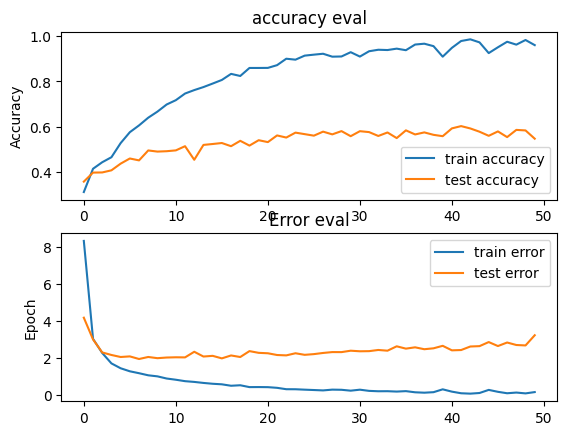

In [ ]:
plot_history(history)

In [ ]:
#build network topology
model_reqularized=keras.Sequential([
        #input layer
        keras.layers.Flatten(input_shape=(X.shape[1],X.shape[2])),
        #1. dense layer
        keras.layers.Dense(512,activation="relu",kernel_regularizer=keras.regularizers.L2(0.001)),
        keras.layers.Dropout(0.3),
        #2.dense layer
        keras.layers.Dense(256,activation="relu",kernel_regularizer=keras.regularizers.L2(0.001)),
        keras.layers.Dropout(0.3),
        #3.dense layer
        keras.layers.Dense(64,activation="relu",kernel_regularizer=keras.regularizers.L2(0.001)),
        keras.layers.Dropout(0.3),
        #output layer
        keras.layers.Dense(10,activation="softmax")])



In [ ]:
#compile model
optimizer=keras.optimizers.Adam(learning_rate=0.0001)
model_reqularized.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1690)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               865792    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 1,014,218
Trainable params: 1,014,218
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model_reqularized.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=32)

Epoch 1/100
219/219 [==============================] - 3s 10ms/step - loss: 25.0754 - accuracy: 0.1422 - val_loss: 3.6389 - val_accuracy: 0.1078
Epoch 2/100
219/219 [==============================] - 2s 9ms/step - loss: 6.4072 - accuracy: 0.1392 - val_loss: 3.5611 - val_accuracy: 0.1101
Epoch 3/100
219/219 [==============================] - 2s 9ms/step - loss: 4.3630 - accuracy: 0.1189 - val_loss: 3.5200 - val_accuracy: 0.1041
Epoch 4/100
219/219 [==============================] - 2s 9ms/step - loss: 3.8812 - accuracy: 0.1196 - val_loss: 3.4979 - val_accuracy: 0.1005
Epoch 5/100
219/219 [==============================] - 2s 9ms/step - loss: 3.6832 - accuracy: 0.1300 - val_loss: 3.4835 - val_accuracy: 0.1075
Epoch 6/100
219/219 [==============================] - 2s 9ms/step - loss: 3.6247 - accuracy: 0.1316 - val_loss: 3.4771 - val_accuracy: 0.1081
Epoch 7/100
219/219 [==============================] - 2s 9ms/step - loss: 3.5229 - accuracy: 0.1348 - val_loss: 3.4679 - val_accuracy: 0.10

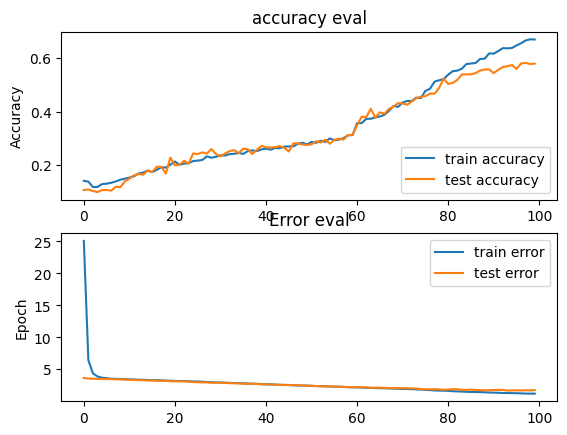

In [ ]:
plot_history(history)

In [ ]:
#EVRİŞİMLİ SİNİR AĞI
#train,dogrulama ve test durumları olustur
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)
X_train,X_validation,y_train,y_validation=train_test_split(X_train,y_train,test_size=0.2)

#giris kümelerine eksen ekle
X_train=X_train[...,np.newaxis]
X_validation=X_validation[...,np.newaxis]
X_test=X_test[...,np.newaxis]


In [ ]:
X_train.shape

(5991, 130, 13, 1)

In [ ]:
input_shape=(X_train.shape[1],X_train.shape[2],1)


In [ ]:
#CNN olustur 
model_cnn=keras.Sequential()
#1.conv layer
model_cnn.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape))
model_cnn.add(keras.layers.MaxPooling2D((3,3),strides=(2,2),padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

#2.conv layer
model_cnn.add(keras.layers.Conv2D(32,(3,3),activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((3,3),strides=(2,2),padding='same'))
model_cnn.add(keras.layers.BatchNormalization())
#3.conv layer
model_cnn.add(keras.layers.Conv2D(32,(2,2),activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((2,2),strides=(2,2),padding='same'))
model_cnn.add(keras.layers.BatchNormalization())
#flatten  output and feed ıt into dense layer
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(64,activation='relu'))
model_cnn.add(keras.layers.Dropout(0.3))
#output layer
model_cnn.add(keras.layers.Dense(10,activation='softmax'))



NameError: name 'keras' is not defined

In [ ]:
#modeli compile et
optimizer=keras.optimizers.Adam(learning_rate=0.0001)
model_cnn.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])


In [ ]:
model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                      

In [ ]:
history=model_cnn.fit(X_train,y_train,validation_data=(X_validation,y_validation),epochs=50,batch_size=32)

Epoch 1/50
188/188 [==============================] - 7s 31ms/step - loss: 2.3369 - accuracy: 0.2485 - val_loss: 1.7794 - val_accuracy: 0.3685
Epoch 2/50
188/188 [==============================] - 5s 28ms/step - loss: 1.8212 - accuracy: 0.3709 - val_loss: 1.5009 - val_accuracy: 0.4599
Epoch 3/50
188/188 [==============================] - 5s 28ms/step - loss: 1.5996 - accuracy: 0.4303 - val_loss: 1.3725 - val_accuracy: 0.5080
Epoch 4/50
188/188 [==============================] - 5s 28ms/step - loss: 1.4845 - accuracy: 0.4625 - val_loss: 1.3016 - val_accuracy: 0.5220
Epoch 5/50
188/188 [==============================] - 5s 28ms/step - loss: 1.3828 - accuracy: 0.5041 - val_loss: 1.2444 - val_accuracy: 0.5467
Epoch 6/50
188/188 [==============================] - 5s 28ms/step - loss: 1.3304 - accuracy: 0.5171 - val_loss: 1.2241 - val_accuracy: 0.5547
Epoch 7/50
188/188 [==============================] - 5s 28ms/step - loss: 1.2871 - accuracy: 0.5295 - val_loss: 1.1761 - val_accuracy: 0.5701

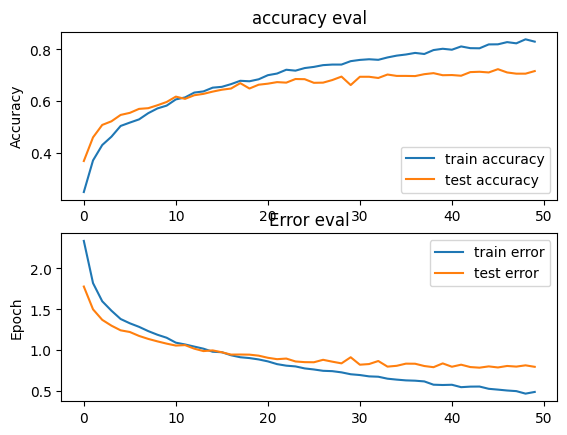

In [ ]:
plot_history(history)

In [ ]:
#modeli test setinde değerlendir(evaluate )
test_loss,test_accuracy=model_cnn.evaluate(X_test,y_test,verbose=2)
print("\n Test Doğruluğu: ",test_accuracy) 

79/79 - 1s - loss: 0.7528 - accuracy: 0.7485 - 1s/epoch - 13ms/step

 Test Doğruluğu:  0.7484982013702393


In [ ]:
model_cnn.save("Musik_turu_Siniflandirma_CNN")


INFO:tensorflow:Assets written to: Musik_turu_Siniflandirma_CNN\assets


INFO:tensorflow:Assets written to: Musik_turu_Siniflandirma_CNN\assets


In [ ]:
model_cnn.save("Muzik_turu_siniflandirma_CNN.h5")


In [ ]:
#modeli aynı şekilde yeniden oluşturmak için kullanılabilir
reconstructed_model=keras.models.load_model("Muzik_turu_siniflandirma_CNN.h5")


In [ ]:
#test setinde tahmin
#test setinden tahmin etmek için bir örnek seç
X_to_predict=X_test[100]
y_to_predict=y_test[100]


In [ ]:
X_to_predict.shape

(130, 13, 1)

In [ ]:
print(" Gerçek Tür:",y_to_predict)

 Gerçek Tür: 2


In [ ]:
#örnek model için girdi verilerine bir boyut ekler.
X_to_predict=X_to_predict[np.newaxis,...]#array shape [1,130,13,1]



In [ ]:
X_to_predict.shape

(1, 130, 13, 1)

In [ ]:
#tahmini gerçekleştirir
prediction=model_cnn.predict(X_to_predict)


1/1 [==============================] - 0s 197ms/step


In [ ]:
#maksimum değere sahip dizin alır
predicted_index=np.argmax(prediction,axis=1)

print("Tahmini Tür:",int(predicted_index))


Tahmini Tür: 7


In [ ]:
#test setinden tahmin etmek için bir örnek seçer
X_to_predict=X_test[50]
y_to_predict=y_test[50]
print("Gerçek Tür:",y_to_predict)

#maksimum değere sahip dizin alır
predicted_index=np.argmax(prediction,axis=1)
print("Tahmin edilen tür: ",int(predicted_index))


Gerçek Tür: 8
Tahmin edilen tür:  7


In [ ]:
len(X_test)

2497

In [ ]:
for n in range(10):
    i=random.randint(0,len(X_test))
    #TEST SETİNDEN TAHMİN ETMEK İÇİN BİR ÖRNEK SEÇ
    X_to_predict=X_test[i]
    y_to_predict=y_test[i]

    print("\n Gerçek Tür:",y_to_predict)

    X_to_predict=X_to_predict[np.newaxis,...]
    prediction=model_cnn.predict(X_to_predict)
    #maksimum değere sahip dizin al
    predicted_index=np.argmax(prediction,axis=1)

    print("Tahmin Edilen Tür:",int(predicted_index))



 Gerçek Tür: 7
1/1 [==============================] - 0s 27ms/step
Tahmin Edilen Tür: 7

 Gerçek Tür: 3
1/1 [==============================] - 0s 29ms/step
Tahmin Edilen Tür: 3

 Gerçek Tür: 6
1/1 [==============================] - 0s 33ms/step
Tahmin Edilen Tür: 6

 Gerçek Tür: 0
1/1 [==============================] - 0s 27ms/step
Tahmin Edilen Tür: 0

 Gerçek Tür: 3
1/1 [==============================] - 0s 32ms/step
Tahmin Edilen Tür: 3

 Gerçek Tür: 8
1/1 [==============================] - 0s 29ms/step
Tahmin Edilen Tür: 7

 Gerçek Tür: 6
1/1 [==============================] - 0s 22ms/step
Tahmin Edilen Tür: 6

 Gerçek Tür: 7
1/1 [==============================] - 0s 21ms/step
Tahmin Edilen Tür: 7

 Gerçek Tür: 0
1/1 [==============================] - 0s 25ms/step
Tahmin Edilen Tür: 9

 Gerçek Tür: 7
1/1 [==============================] - 0s 24ms/step
Tahmin Edilen Tür: 7


In [ ]:
#yeni şarkı tahmini
def process_input(audio_file,track_duration):
    SAMPLE_RATE=22050
    NUM_MFCC=13
    N_FFT=2048
    HOP_LENGTH=512
    TRACK_DURATION=track_duration#saniye cinsinden ölçülür
    SAMPLE_PER_TRACK=SAMPLE_RATE*TRACK_DURATION
    NUM_SEGMENT=10
    samples_per_segment=int(SAMPLE_PER_TRACK/NUM_SEGMENT)
    
    #num_mfcc_vectors_per_segment=math.ceil(samples_per_segment/HOP_LENGTH)

    signal,sr=librosa.load(audio_file,sr=SAMPLE_RATE)

    for d in range(10):
        #geçerli segment için başlangıç ve bitiş örneğini hesaplar
        start=samples_per_segment*d
        finish=start+samples_per_segment

        #mfcc'yi ayıklar
        mfcc=librosa.feature.mfcc(signal[start:finish],sr,n_mfcc=NUM_MFCC,n_fft=N_FFT,hop_length=HOP_LENGTH)
        mfcc=mfcc.T
        return mfcc

In [ ]:
genre_dict={0:"blues",1:"classical",2:"country",3:"disco",4:"hiphop",5:"jazz",6:"metal",7:"pop",8:"reggae",9:"rock"}



In [ ]:
new_input_mfcc=process_input("C:/Users/evsin/OneDrive/Masaüstü/music_turu_siniiflandirma/louis-armstrong-what-a-wonderful-world-lyrics.mp3",30)

In [ ]:
type(new_input_mfcc)

numpy.ndarray

In [ ]:
new_input_mfcc.shape

(130, 13)

In [ ]:
X_to_predict=new_input_mfcc[np.newaxis,...,np.newaxis]
X_to_predict.shape


(1, 130, 13, 1)

In [ ]:
prediction=model_cnn.predict(X_to_predict)
#maksimum değere sahip dizini al
predicted_index=np.argmax(prediction,axis=1)
print("Tahmin edilen tür: ",genre_dict[int(predicted_index)])


NameError: name 'model_cnn' is not defined